In [1]:
### Hyperparameter Optimization with Logistic Regression
# Setup and import

import numpy as np
import pandas as pd
import sklearn.metrics as skm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import anndata
import os

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

NumPy version: 2.0.2
Pandas version: 2.3.3


In [2]:
# Set working directory
# Replace with your actual path (same as Day 1)
os.chdir("..")  

# Verify current directory
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/tardis/Library/CloudStorage/GoogleDrive-natrdn@gmail.com/My Drive/Natália (Academic Folder)/Post_doc/ML_pred_scRNA


In [3]:
# Load and prepare data
# The dataset (same as Day 1)
data = anndata.read_h5ad("data/my_dataset_small.h5ad")

print("=" * 60)
print("DATA LOADING")
print("=" * 60)
print(f"Original data shape: {data.shape}")
print(f"Cells: {data.n_obs}, Genes: {data.n_vars}")

# Summarize cell types
print("\nCell type distribution (author_cell_type):")
print(data.obs["author_cell_type"].value_counts())

DATA LOADING
Original data shape: (2988, 33159)
Cells: 2988, Genes: 33159

Cell type distribution (author_cell_type):
author_cell_type
Neurons - glutamatergic upper layer 3                  451
Neurons - glutamatergic upper layer 1                  313
Neurons - glutamatergic deep layer, epithelial-like    310
Neurons - glutamatergic deep layer 2                   271
Astrocytes                                             264
Neurons - glutamatergic deep layer 3                   259
Neuroblasts - NHLH1 1                                  196
Neurons - glutamatergic upper layer 2                  192
Neuroblasts - NHLH1 2                                  177
Glioblasts                                             176
Neuroblasts - NHLH2                                    136
Neurons - glutamatergic deep layer 1                   136
Neurons - GABAergic                                    107
Name: count, dtype: int64


In [4]:
# Normalize and filter (Same as day 1)
from scipy import sparse

print("\n" + "=" * 60)
print("NORMALIZATION AND FILTERING")
print("=" * 60)

# Normalize total counts per cell
# (same logic as Instructions1, but using anndata utilities if desired)
X = data.X

# Ensure CSR format for safe row operations
if not sparse.isspmatrix_csr(X):
    X = X.tocsr()

# 1. Sum per cell
cell_sums = np.array(X.sum(axis=1)).flatten()

# Avoid division by zero
cell_sums[cell_sums == 0] = 1.0

# 2. Normalize by total counts
X = X.multiply(1.0 / cell_sums[:, None])

# 3. Multiply by 1e6
X = X.multiply(1e6)

# 4. Log1p transform
X = X.log1p()

# 5. Back to CSR (if needed)
X = X.tocsr()

# Replace data.X with normalized values
data.X = X

print("Finished normalization and log transformation.")
print(f"Data matrix type: {type(data.X)}")
print(f"Data matrix shape: {data.X.shape}")


NORMALIZATION AND FILTERING
Finished normalization and log transformation.
Data matrix type: <class 'scipy.sparse._csr.csr_matrix'>
Data matrix shape: (2988, 33159)


In [5]:
# Filter lowly expressed genes (same as day 1)
print("\nFiltering lowly expressed genes...")

# Number of cells
n_cells = data.n_obs

# Sum expression per gene
gene_sums = np.array(data.X.sum(axis=0)).flatten()

# Keep genes expressed in at least 10% of cells
gene_filter = gene_sums > 0.1 * n_cells
data = data[:, gene_filter].copy()

print(f"After filtering:")
print(f"Data shape: {data.shape}")
print(f"Cells: {data.n_obs}, Genes: {data.n_vars}")


Filtering lowly expressed genes...
After filtering:
Data shape: (2988, 13080)
Cells: 2988, Genes: 13080


In [6]:
### Setup data and tensors (X and Y)
print("\n" + "=" * 60)
print("SETUP X AND Y (Same as Day 1)")
print("=" * 60)

# Input X: normalized, filtered gene expression (dense array for sklearn)
X = data.X
if hasattr(X, "toarray"):
    X = X.toarray()

print(f"X shape: {X.shape}")
print(f"X dtype: {X.dtype}")

# Output Y: use a cell-type label, as in Day 1 (e.g., 'author_cell_type')
Y = data.obs["author_cell_type"].tolist()

print(f"Number of labels: {len(Y)}")
print(f"Example labels: {Y[:10]}")


SETUP X AND Y (Same as Day 1)
X shape: (2988, 13080)
X dtype: float32
Number of labels: 2988
Example labels: ['Neurons - glutamatergic upper layer 1', 'Neurons - glutamatergic upper layer 1', 'Neurons - glutamatergic upper layer 1', 'Neurons - glutamatergic upper layer 1', 'Neurons - glutamatergic upper layer 1', 'Neurons - glutamatergic upper layer 1', 'Neurons - glutamatergic upper layer 1', 'Neurons - glutamatergic upper layer 1', 'Neurons - glutamatergic upper layer 1', 'Neurons - glutamatergic upper layer 1']


In [7]:
# Define models / hyperparameters
print("\n" + "=" * 60)
print("MODEL DEFINITIONS")
print("=" * 60)

# model1: little regularization (C=1000.0, l2 penalty)
model1 = LogisticRegression(
    penalty="l2", # l2 loss ("ridge")
    C=1000.0, # regularization strength
    max_iter=200,
    multi_class="auto",
    solver="lbfgs"
)

# model2: more regularization (C=1, l2 penalty)
model2 = LogisticRegression(
    penalty="l2", # l2 loss ("ridge")
    C=1.0, # regularization strength
    max_iter=200,
    multi_class="auto",
    solver="lbfgs"
)

print("Defined two logistic regression models:")
print("  model1: L2 penalty, C=1000.0 (little regularization)")
print("  model2: L2 penalty, C=1.0    (stronger regularization)")


MODEL DEFINITIONS
Defined two logistic regression models:
  model1: L2 penalty, C=1000.0 (little regularization)
  model2: L2 penalty, C=1.0    (stronger regularization)


In [8]:
### Cross-validation (5-fold) for hyperparameter optimization
# Split into test and cv data
print("\n" + "=" * 60)
print("TRAIN/TEST SPLIT")
print("=" * 60)

# Split into CV and test data (25% test) - DO NOT TOUCH TEST IN CV LOOP
X_cv, X_test, Y_cv, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=Y
)

print(f"X_cv shape:   {X_cv.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_cv size:    {len(Y_cv)}")
print(f"Y_test size:  {len(Y_test)}")


TRAIN/TEST SPLIT
X_cv shape:   (2241, 13080)
X_test shape: (747, 13080)
Y_cv size:    2241
Y_test size:  747


In [9]:
# 5-fold cross-validation loop
print("\n" + "=" * 60)
print("5-FOLD CROSS-VALIDATION")
print("=" * 60)

# Helps decide between the two models
model_choice = 0

# To store validation accuracies in each fold
val_acc_model1 = []
val_acc_model2 = []

n_folds = 5

for fold in range(1, n_folds + 1):
    print(f"\n--- Fold {fold}/{n_folds} ---")

    # 1. Split CV data into train and validation (30% validation)
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_cv, Y_cv, test_size=0.30, random_state=fold, stratify=Y_cv
    )

    print(f"Train size: {len(Y_train)}, Val size: {len(Y_val)}")

    # 2. Fit both models on training data
    model1.fit(X_train, Y_train)
    model2.fit(X_train, Y_train)

    # 3. Predict on validation data
    Yhat_val_1 = model1.predict(X_val)
    Yhat_val_2 = model2.predict(X_val)

    # 4. Calculate accuracy on validation data
    acc1 = skm.accuracy_score(Y_val, Yhat_val_1)
    acc2 = skm.accuracy_score(Y_val, Yhat_val_2)

    val_acc_model1.append(acc1)
    val_acc_model2.append(acc2)

    # 5. Print accuracies
    print(f"Validation accuracy model1 (C=1000.0): {acc1:.4f}")
    print(f"Validation accuracy model2 (C=1.0):    {acc2:.4f}")

    # 6. Update model_choice
    if acc1 > acc2:
        model_choice += 1
        print("  → model1 wins this fold (model_choice +1)")
    elif acc2 > acc1:
        model_choice -= 1
        print("  → model2 wins this fold (model_choice -1)")
    else:
        print("  → Tie in this fold (model_choice unchanged)")

print("\n" + "=" * 60)
print("CROSS-VALIDATION SUMMARY")
print("=" * 60)
print(f"Validation accuracies model1: {val_acc_model1}")
print(f"Validation accuracies model2: {val_acc_model2}")
print(f"\nFinal model_choice value: {model_choice}")


5-FOLD CROSS-VALIDATION

--- Fold 1/5 ---
Train size: 1568, Val size: 673


/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation accuracy model1 (C=1000.0): 0.8455
Validation accuracy model2 (C=1.0):    0.8544
  → model2 wins this fold (model_choice -1)

--- Fold 2/5 ---
Train size: 1568, Val size: 673


/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation accuracy model1 (C=1000.0): 0.8425
Validation accuracy model2 (C=1.0):    0.8470
  → model2 wins this fold (model_choice -1)

--- Fold 3/5 ---
Train size: 1568, Val size: 673


/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation accuracy model1 (C=1000.0): 0.8232
Validation accuracy model2 (C=1.0):    0.8470
  → model2 wins this fold (model_choice -1)

--- Fold 4/5 ---
Train size: 1568, Val size: 673


/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation accuracy model1 (C=1000.0): 0.8351
Validation accuracy model2 (C=1.0):    0.8276
  → model1 wins this fold (model_choice +1)

--- Fold 5/5 ---
Train size: 1568, Val size: 673


/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation accuracy model1 (C=1000.0): 0.8470
Validation accuracy model2 (C=1.0):    0.8499
  → model2 wins this fold (model_choice -1)

CROSS-VALIDATION SUMMARY
Validation accuracies model1: [0.8454680534918276, 0.8424962852897474, 0.8231797919762258, 0.8350668647845468, 0.8469539375928677]
Validation accuracies model2: [0.8543833580980683, 0.8469539375928677, 0.8469539375928677, 0.8276374442793462, 0.849925705794948]

Final model_choice value: -3


In [10]:
# Evaluate the better model on the test data
print("\n" + "=" * 60)
print("FINAL MODEL SELECTION AND TEST EVALUATION")
print("=" * 60)

# Decide which model performed better
if model_choice > 0:
    best_model = model1
    best_model_name = "model1 (C=1000.0, little regularization)"
elif model_choice < 0:
    best_model = model2
    best_model_name = "model2 (C=1.0, more regularization)"
else:
    # In case of a tie, choose the more regularized model by default
    best_model = model2
    best_model_name = "model2 (C=1.0, more regularization) [tie-break]"

print(f"Best model selected based on CV: {best_model_name}")

# Retrain best model on ALL CV data (X_cv, Y_cv)
best_model.fit(X_cv, Y_cv)

# Evaluate on the HELD-OUT test data
Yhat_test = best_model.predict(X_test)
test_accuracy = skm.accuracy_score(Y_test, Yhat_test)

print(f"\nTest accuracy of best model on unseen data: {test_accuracy:.4f}")
print("This is the final performance estimate.")


FINAL MODEL SELECTION AND TEST EVALUATION
Best model selected based on CV: model2 (C=1.0, more regularization)


/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Test accuracy of best model on unseen data: 0.8327
This is the final performance estimate.


In [11]:
### Check effect of regularization on coefficients
# Train both models on all cv data
print("\n" + "=" * 60)
print("TRAIN MODELS ON ALL CV DATA")
print("=" * 60)

# Train each model on all CV data (train + validation used during CV)
model1.fit(X_cv, Y_cv)
model2.fit(X_cv, Y_cv)

print("Both models trained on full CV set.")


TRAIN MODELS ON ALL CV DATA


/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/ml_omics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Both models trained on full CV set.



COEFFICIENTS AND HISTOGRAMS
model1 coef_ shape: (13, 13080)
model2 coef_ shape: (13, 13080)


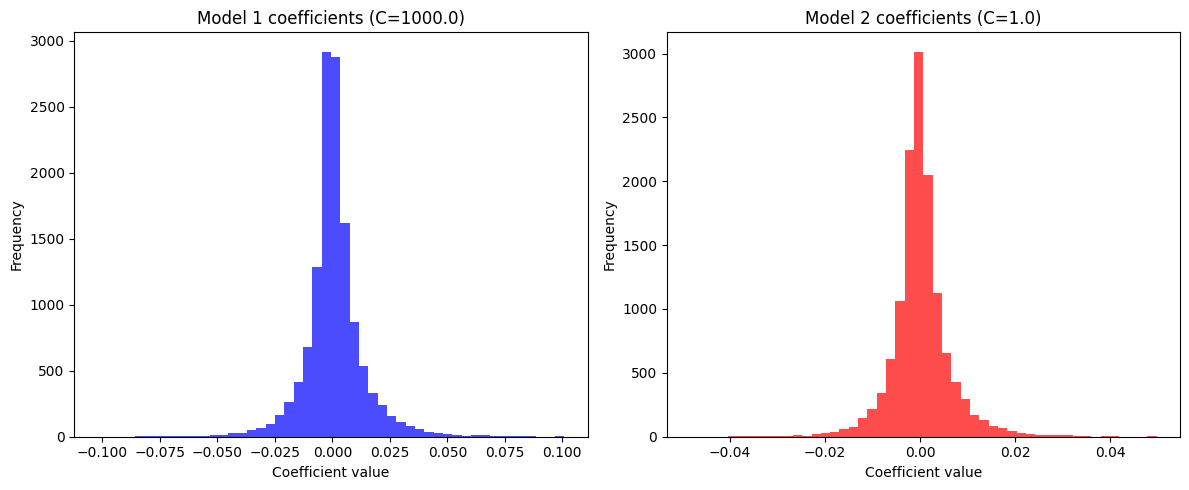

✓ Histograms saved as 'day4_coefficient_histograms.png'


In [12]:
# Inspeact coefficients and histograms
print("\n" + "=" * 60)
print("COEFFICIENTS AND HISTOGRAMS")
print("=" * 60)

coef1 = model1.coef_  # shape: [n_classes, n_features]
coef2 = model2.coef_

print(f"model1 coef_ shape: {coef1.shape}")
print(f"model2 coef_ shape: {coef2.shape}")

# Choose one class (e.g., first row) for histogram
class_idx = 0

coef1_class = coef1[class_idx, :]
coef2_class = coef2[class_idx, :]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(coef1_class, bins=50, alpha=0.7, color="blue")
plt.title("Model 1 coefficients (C=1000.0)")
plt.xlabel("Coefficient value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(coef2_class, bins=50, alpha=0.7, color="red")
plt.title("Model 2 coefficients (C=1.0)")
plt.xlabel("Coefficient value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("day4_coefficient_histograms.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Histograms saved as 'day4_coefficient_histograms.png'")


MEAN ABSOLUTE COEFFICIENTS PER CLASS
Mean absolute coefficients per class:
Class 0: model1=0.0084, model2=0.0041
Class 1: model1=0.0077, model2=0.0038
Class 2: model1=0.0060, model2=0.0030
Class 3: model1=0.0064, model2=0.0033
Class 4: model1=0.0050, model2=0.0027
Class 5: model1=0.0049, model2=0.0022
Class 6: model1=0.0046, model2=0.0028
Class 7: model1=0.0056, model2=0.0036
Class 8: model1=0.0058, model2=0.0035
Class 9: model1=0.0077, model2=0.0037
Class 10: model1=0.0069, model2=0.0039
Class 11: model1=0.0055, model2=0.0036
Class 12: model1=0.0073, model2=0.0045


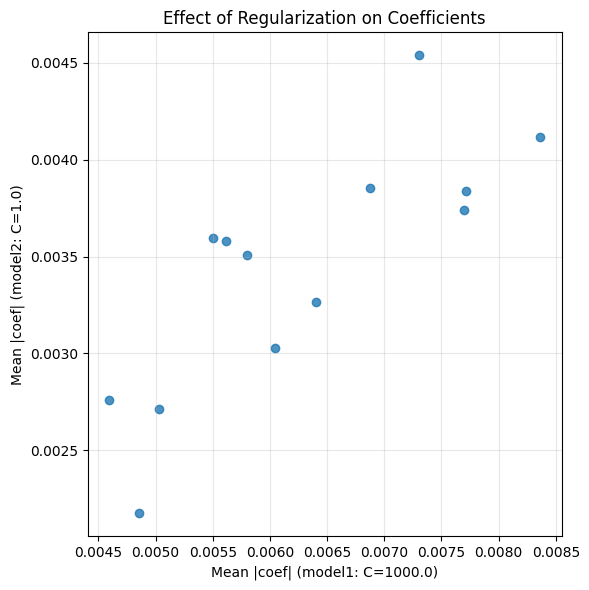

✓ Scatterplot saved as 'day4_regularization_effect.png'


In [13]:
# Compare mean absolute coefficients per class
print("\n" + "=" * 60)
print("MEAN ABSOLUTE COEFFICIENTS PER CLASS")
print("=" * 60)

# Absolute values
abs_coef1 = np.abs(coef1)
abs_coef2 = np.abs(coef2)

mean_abs_coef1 = abs_coef1.mean(axis=1)  # per class
mean_abs_coef2 = abs_coef2.mean(axis=1)  # per class

classes = np.arange(coef1.shape[0])

print("Mean absolute coefficients per class:")
for i, (m1, m2) in enumerate(zip(mean_abs_coef1, mean_abs_coef2)):
    print(f"Class {i}: model1={m1:.4f}, model2={m2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(mean_abs_coef1, mean_abs_coef2, alpha=0.8)
plt.xlabel("Mean |coef| (model1: C=1000.0)")
plt.ylabel("Mean |coef| (model2: C=1.0)")
plt.title("Effect of Regularization on Coefficients")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("day4_regularization_effect.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Scatterplot saved as 'day4_regularization_effect.png'")

In [14]:
### To be mindful
# Descrive objects
print("\n" + "=" * 60)
print("EXERCISE 1.1: Object Descriptions")
print("=" * 60)

# 1. Training inputs X_cv
print("\n1. Training inputs 'X_cv':")
print(f"   Type: {type(X_cv)}")
print(f"   Shape: {X_cv.shape}")
print(f"   Dtype: {X_cv.dtype}")
print(f"   Value range: [{X_cv.min():.4f}, {X_cv.max():.4f}]")

# 2. Test inputs X_test
print("\n2. Test inputs 'X_test':")
print(f"   Type: {type(X_test)}")
print(f"   Shape: {X_test.shape}")
print(f"   Dtype: {X_test.dtype}")
print(f"   Value range: [{X_test.min():.4f}, {X_test.max():.4f}]")

# 3. Training labels Y_cv
print("\n3. Training labels 'Y_cv':")
print(f"   Type: {type(Y_cv)}")
print(f"   Length: {len(Y_cv)}")
print(f"   Example labels: {Y_cv[:10]}")
print(f"   Unique labels: {pd.Series(Y_cv).unique().tolist()}")

# 4. Test labels Y_test
print("\n4. Test labels 'Y_test':")
print(f"   Type: {type(Y_test)}")
print(f"   Length: {len(Y_test)}")
print(f"   Example labels: {Y_test[:10]}")
print(f"   Unique labels: {pd.Series(Y_test).unique().tolist()}")

# 5. Model coefficients of models 1 and 2
print("\n5. Model coefficients:")

print("   model1.coef_:")
print(f"     Type: {type(coef1)}")
print(f"     Shape: {coef1.shape}")
print(f"     Value range: [{coef1.min():.4f}, {coef1.max():.4f}]")

print("   model2.coef_:")
print(f"     Type: {type(coef2)}")
print(f"     Shape: {coef2.shape}")
print(f"     Value range: [{coef2.min():.4f}, {coef2.max():.4f}]")


EXERCISE 1.1: Object Descriptions

1. Training inputs 'X_cv':
   Type: <class 'numpy.ndarray'>
   Shape: (2241, 13080)
   Dtype: float32
   Value range: [0.0000, 12.7141]

2. Test inputs 'X_test':
   Type: <class 'numpy.ndarray'>
   Shape: (747, 13080)
   Dtype: float32
   Value range: [0.0000, 12.4450]

3. Training labels 'Y_cv':
   Type: <class 'list'>
   Length: 2241
   Example labels: ['Neurons - glutamatergic upper layer 3', 'Neurons - glutamatergic deep layer, epithelial-like', 'Neurons - glutamatergic deep layer 1', 'Neurons - glutamatergic deep layer 2', 'Astrocytes', 'Neuroblasts - NHLH1 2', 'Neurons - glutamatergic deep layer 2', 'Neurons - glutamatergic deep layer 3', 'Neuroblasts - NHLH1 1', 'Neurons - glutamatergic upper layer 3']
   Unique labels: ['Neurons - glutamatergic upper layer 3', 'Neurons - glutamatergic deep layer, epithelial-like', 'Neurons - glutamatergic deep layer 1', 'Neurons - glutamatergic deep layer 2', 'Astrocytes', 'Neuroblasts - NHLH1 2', 'Neurons - 

In [15]:
# Which model performed better
print("\n" + "=" * 60)
print("EXERCISE 1.2: Which Model Performed Better?")
print("=" * 60)

print(f"Validation accuracies (model1): {val_acc_model1}")
print(f"Validation accuracies (model2): {val_acc_model2}")
print(f"Final model_choice: {model_choice}")

wins_model1 = sum(a > b for a, b in zip(val_acc_model1, val_acc_model2))
wins_model2 = sum(b > a for a, b in zip(val_acc_model1, val_acc_model2))
ties        = sum(a == b for a, b in zip(val_acc_model1, val_acc_model2))

print(f"\nmodel1 better in {wins_model1} folds.")
print(f"model2 better in {wins_model2} folds.")
print(f"Ties in {ties} folds.")

if model_choice > 0:
    print("\n→ Overall, model1 performed better across folds.")
elif model_choice < 0:
    print("\n→ Overall, model2 performed better across folds.")
else:
    print("\n→ Overall, performance was tied across folds.")


EXERCISE 1.2: Which Model Performed Better?
Validation accuracies (model1): [0.8454680534918276, 0.8424962852897474, 0.8231797919762258, 0.8350668647845468, 0.8469539375928677]
Validation accuracies (model2): [0.8543833580980683, 0.8469539375928677, 0.8469539375928677, 0.8276374442793462, 0.849925705794948]
Final model_choice: -3

model1 better in 1 folds.
model2 better in 4 folds.
Ties in 0 folds.

→ Overall, model2 performed better across folds.


In [17]:
# CV vs Test Accuracy
print("\n" + "=" * 60)
print("EXERCISE 1.3: CV vs Test Accuracy")
print("=" * 60)

mean_val_acc_model1 = np.mean(val_acc_model1)
mean_val_acc_model2 = np.mean(val_acc_model2)

print(f"Mean validation accuracy model1: {mean_val_acc_model1:.4f}")
print(f"Mean validation accuracy model2: {mean_val_acc_model2:.4f}")
print(f"Test accuracy (best model):      {test_accuracy:.4f}")



EXERCISE 1.3: CV vs Test Accuracy
Mean validation accuracy model1: 0.8386
Mean validation accuracy model2: 0.8452
Test accuracy (best model):      0.8327


In [20]:
# Effect of Regularization on Coefficients
print("\n" + "=" * 60)
print("EXERCISE 1.4: Effect of Regularization")
print("=" * 60)

print("Mean absolute coefficients (per class):")
for i, (m1, m2) in enumerate(zip(mean_abs_coef1, mean_abs_coef2)):
    print(f"  Class {i}: model1={m1:.4f}, model2={m2:.4f}")
# large coefficients to be penalized, 
# coefficients to be pulled toward zero, and extreme weights to be discouraged


EXERCISE 1.4: Effect of Regularization
Mean absolute coefficients (per class):
  Class 0: model1=0.0084, model2=0.0041
  Class 1: model1=0.0077, model2=0.0038
  Class 2: model1=0.0060, model2=0.0030
  Class 3: model1=0.0064, model2=0.0033
  Class 4: model1=0.0050, model2=0.0027
  Class 5: model1=0.0049, model2=0.0022
  Class 6: model1=0.0046, model2=0.0028
  Class 7: model1=0.0056, model2=0.0036
  Class 8: model1=0.0058, model2=0.0035
  Class 9: model1=0.0077, model2=0.0037
  Class 10: model1=0.0069, model2=0.0039
  Class 11: model1=0.0055, model2=0.0036
  Class 12: model1=0.0073, model2=0.0045
